# PMEmo Dataset - Feed Forward Neural Network
## Essentia Best Overall openSMILE GeMAPS Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_pmemo_path('processed/annotations/pmemo_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,1,0.150,-0.200
1,4,-0.425,-0.475
2,5,-0.600,-0.700
3,6,-0.300,0.025
4,7,0.450,0.400
...,...,...,...
762,993,0.525,0.725
763,996,0.125,0.750
764,997,0.325,0.425
765,999,0.550,0.750


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_overall_opensmile_gemaps = pd.read_csv(get_pmemo_path('processed/features/integrated/standardised_essentia_best_overall_opensmile_gemaps_features.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_opensmile_gemaps = df_essentia_best_overall_opensmile_gemaps[df_essentia_best_overall_opensmile_gemaps.columns[1:]]

df_essentia_best_overall_opensmile_gemaps

,song_id,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
0,1,-0.213586,-0.223554,-0.205962,-0.189170,0.094015,-0.290830,-0.428626,-0.774106,-0.092809,...,0.010665,0.112443,-0.356517,0.241192,0.626061,0.381042,-0.336055,-0.374205,0.262637,-0.077513
1,4,1.519912,1.444784,0.436868,0.274619,0.907303,2.148017,2.210257,0.082097,1.628937,...,-2.582425,2.521296,-1.587073,-1.756907,1.246634,-2.081171,0.077305,0.364584,13.929680,12.635127
2,5,4.192724,4.051296,3.004901,2.571136,2.095142,4.061978,3.658255,-1.519185,3.431222,...,-2.393781,2.181989,-1.341486,-0.316982,1.247192,-0.483298,-0.156962,-0.196903,0.509336,0.506650
3,6,0.308062,0.278054,-0.185456,-0.169303,-0.301137,0.609811,1.294941,-0.568763,0.097731,...,-0.741640,0.768306,-1.876367,0.705660,0.560435,-0.939150,-0.438867,-0.422328,4.102221,3.583107
4,7,-0.285838,-0.283458,-0.268729,-0.246064,-0.124872,-0.407720,-0.309671,-1.204256,-0.389019,...,0.469653,-0.687136,1.506562,-0.467269,0.347808,-0.244452,-0.097217,-0.183003,-0.546643,-0.583730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,993,-0.375556,-0.349878,-0.246022,-0.213527,0.509430,-0.341976,-0.341794,-1.504569,-0.282898,...,0.612326,-0.673763,0.581939,0.317231,-0.272794,0.346534,-0.296380,0.179435,0.009848,-0.110172
763,996,0.108256,-0.003168,0.049535,-0.012648,1.028387,0.208018,-0.498191,-0.337371,0.952869,...,0.502963,-0.119092,0.708211,1.645550,0.506390,0.734247,-0.376792,-0.392740,0.211598,0.131591
764,997,-0.431716,-0.421521,-0.304278,-0.273126,-0.286054,-0.448361,-0.361876,-1.369817,-0.487787,...,0.785432,-0.498027,0.274327,1.052788,-0.036849,0.200898,-0.273511,-0.243128,0.080631,1.233979
765,999,-0.387322,-0.389485,-0.311137,-0.281734,-0.391420,-0.296933,-0.228861,0.697357,-0.370472,...,0.605529,-0.365492,-0.185980,1.193421,-0.851040,0.757317,-0.403438,-0.260820,0.378455,2.290346


In [4]:
df_essentia_best_overall_opensmile_gemaps.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 199 columns):
 #    Column                                          Dtype  
---   ------                                          -----  
 0    song_id                                         int64  
 1    lowlevel.melbands_kurtosis.dmean                float64
 2    lowlevel.melbands_kurtosis.dmean2               float64
 3    lowlevel.melbands_kurtosis.dvar                 float64
 4    lowlevel.melbands_kurtosis.dvar2                float64
 5    lowlevel.melbands_kurtosis.max                  float64
 6    lowlevel.melbands_kurtosis.mean                 float64
 7    lowlevel.melbands_kurtosis.median               float64
 8    lowlevel.melbands_kurtosis.min                  float64
 9    lowlevel.melbands_kurtosis.stdev                float64
 10   lowlevel.melbands_kurtosis.var                  float64
 11   lowlevel.melbands_skewness.dmean                float64
 12   lowlevel.melbands_sk

Join both the featureset and annotation set together

In [5]:
df_essentia_best_overall_opensmile_gemaps_whole = pd.merge(df_essentia_best_overall_opensmile_gemaps, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_opensmile_gemaps_whole = df_essentia_best_overall_opensmile_gemaps_whole.drop('song_id', axis=1)
df_essentia_best_overall_opensmile_gemaps_whole

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,valence_mean_mapped,arousal_mean_mapped
0,-0.213586,-0.223554,-0.205962,-0.189170,0.094015,-0.290830,-0.428626,-0.774106,-0.092809,-0.259203,...,-0.356517,0.241192,0.626061,0.381042,-0.336055,-0.374205,0.262637,-0.077513,0.150,-0.200
1,1.519912,1.444784,0.436868,0.274619,0.907303,2.148017,2.210257,0.082097,1.628937,1.007622,...,-1.587073,-1.756907,1.246634,-2.081171,0.077305,0.364584,13.929680,12.635127,-0.425,-0.475
2,4.192724,4.051296,3.004901,2.571136,2.095142,4.061978,3.658255,-1.519185,3.431222,3.762238,...,-1.341486,-0.316982,1.247192,-0.483298,-0.156962,-0.196903,0.509336,0.506650,-0.600,-0.700
3,0.308062,0.278054,-0.185456,-0.169303,-0.301137,0.609811,1.294941,-0.568763,0.097731,-0.184629,...,-1.876367,0.705660,0.560435,-0.939150,-0.438867,-0.422328,4.102221,3.583107,-0.300,0.025
4,-0.285838,-0.283458,-0.268729,-0.246064,-0.124872,-0.407720,-0.309671,-1.204256,-0.389019,-0.342705,...,1.506562,-0.467269,0.347808,-0.244452,-0.097217,-0.183003,-0.546643,-0.583730,0.450,0.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,-0.375556,-0.349878,-0.246022,-0.213527,0.509430,-0.341976,-0.341794,-1.504569,-0.282898,-0.317327,...,0.581939,0.317231,-0.272794,0.346534,-0.296380,0.179435,0.009848,-0.110172,0.525,0.725
763,0.108256,-0.003168,0.049535,-0.012648,1.028387,0.208018,-0.498191,-0.337371,0.952869,0.351178,...,0.708211,1.645550,0.506390,0.734247,-0.376792,-0.392740,0.211598,0.131591,0.125,0.750
764,-0.431716,-0.421521,-0.304278,-0.273126,-0.286054,-0.448361,-0.361876,-1.369817,-0.487787,-0.361773,...,0.274327,1.052788,-0.036849,0.200898,-0.273511,-0.243128,0.080631,1.233979,0.325,0.425
765,-0.387322,-0.389485,-0.311137,-0.281734,-0.391420,-0.296933,-0.228861,0.697357,-0.370472,-0.338635,...,-0.185980,1.193421,-0.851040,0.757317,-0.403438,-0.260820,0.378455,2.290346,0.550,0.750


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_overall_opensmile_gemaps.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
0,-0.213586,-0.223554,-0.205962,-0.189170,0.094015,-0.290830,-0.428626,-0.774106,-0.092809,-0.259203,...,0.010665,0.112443,-0.356517,0.241192,0.626061,0.381042,-0.336055,-0.374205,0.262637,-0.077513
1,1.519912,1.444784,0.436868,0.274619,0.907303,2.148017,2.210257,0.082097,1.628937,1.007622,...,-2.582425,2.521296,-1.587073,-1.756907,1.246634,-2.081171,0.077305,0.364584,13.929680,12.635127
2,4.192724,4.051296,3.004901,2.571136,2.095142,4.061978,3.658255,-1.519185,3.431222,3.762238,...,-2.393781,2.181989,-1.341486,-0.316982,1.247192,-0.483298,-0.156962,-0.196903,0.509336,0.506650
3,0.308062,0.278054,-0.185456,-0.169303,-0.301137,0.609811,1.294941,-0.568763,0.097731,-0.184629,...,-0.741640,0.768306,-1.876367,0.705660,0.560435,-0.939150,-0.438867,-0.422328,4.102221,3.583107
4,-0.285838,-0.283458,-0.268729,-0.246064,-0.124872,-0.407720,-0.309671,-1.204256,-0.389019,-0.342705,...,0.469653,-0.687136,1.506562,-0.467269,0.347808,-0.244452,-0.097217,-0.183003,-0.546643,-0.583730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,-0.375556,-0.349878,-0.246022,-0.213527,0.509430,-0.341976,-0.341794,-1.504569,-0.282898,-0.317327,...,0.612326,-0.673763,0.581939,0.317231,-0.272794,0.346534,-0.296380,0.179435,0.009848,-0.110172
763,0.108256,-0.003168,0.049535,-0.012648,1.028387,0.208018,-0.498191,-0.337371,0.952869,0.351178,...,0.502963,-0.119092,0.708211,1.645550,0.506390,0.734247,-0.376792,-0.392740,0.211598,0.131591
764,-0.431716,-0.421521,-0.304278,-0.273126,-0.286054,-0.448361,-0.361876,-1.369817,-0.487787,-0.361773,...,0.785432,-0.498027,0.274327,1.052788,-0.036849,0.200898,-0.273511,-0.243128,0.080631,1.233979
765,-0.387322,-0.389485,-0.311137,-0.281734,-0.391420,-0.296933,-0.228861,0.697357,-0.370472,-0.338635,...,0.605529,-0.365492,-0.185980,1.193421,-0.851040,0.757317,-0.403438,-0.260820,0.378455,2.290346


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,0.150,-0.200
1,-0.425,-0.475
2,-0.600,-0.700
3,-0.300,0.025
4,0.450,0.400
...,...,...
762,0.525,0.725
763,0.125,0.750
764,0.325,0.425
765,0.550,0.750


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [12]:
num_epochs = 115

Set a random seed to ensure consistent initial weights of the neural network

In [13]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [15]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([613, 198])


Training loop

In [16]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [17]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.671629971913036
Epoch 2, Loss: 0.6687333265347284
Epoch 3, Loss: 0.6658749249979059
Epoch 4, Loss: 0.6630580036644803
Epoch 5, Loss: 0.6602850342583926
Epoch 6, Loss: 0.6575572753298399
Epoch 7, Loss: 0.6548699673224264
Epoch 8, Loss: 0.6522958475216714
Epoch 9, Loss: 0.6499293756631087
Epoch 10, Loss: 0.6475795217235044
Epoch 11, Loss: 0.6452608314131224
Epoch 12, Loss: 0.6429649510508926
Epoch 13, Loss: 0.6407438958718576
Epoch 14, Loss: 0.638606333504788
Epoch 15, Loss: 0.6365967616138789
Epoch 16, Loss: 0.6345868842020792
Epoch 17, Loss: 0.6325761801185782
Epoch 18, Loss: 0.6305610494635719
Epoch 19, Loss: 0.628548798951053
Epoch 20, Loss: 0.6265312272636504
Epoch 21, Loss: 0.6245059206218456
Epoch 22, Loss: 0.6224720374878084
Epoch 23, Loss: 0.6204837946915848
Epoch 24, Loss: 0.6184832816890455
Epoch 25, Loss: 0.6165304187020964
Epoch 26, Loss: 0.6146142892530745
Epoch 27, Loss: 0.6126657787108325
Epoch 28, Loss: 0.610677744872515
Epoch 29, Loss: 0.608694062884326

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [18]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([154, 198])


Generating scores

In [19]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  # metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  # metric.update(test_pred, target_test_labels)
  # adjusted_r2_score = metric.compute()
  # print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [20]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.2371205306603663
Valence RMSE: 0.24559958519576652
Arousal RMSE: 0.22832681812037509
Test R^2 score: tensor([0.3554, 0.6155], dtype=torch.float64)
Test R^2 score (overall): 0.4854757154277499


In [21]:
torch.save(model.state_dict(), '../../models/pmemo_feedforward_nn_essentia_best_overall_opensmile_gemaps_standardised.pt')

True values (test set)

In [22]:
target_test_labels

tensor([[-0.5750,  0.3500],
        [ 0.1250, -0.0250],
        [ 0.2000,  0.4750],
        [ 0.3500,  0.3500],
        [ 0.3000,  0.4500],
        [ 0.3500,  0.0250],
        [ 0.3250, -0.0250],
        [ 0.3750,  0.3500],
        [ 0.1500,  0.1000],
        [ 0.2750,  0.6500],
        [ 0.5000,  0.5250],
        [ 0.0500, -0.3500],
        [ 0.0500,  0.2250],
        [-0.3250, -0.4500],
        [-0.1000,  0.4500],
        [ 0.1250, -0.4000],
        [ 0.3750,  0.5500],
        [ 0.2000, -0.2250],
        [-0.4500, -0.3000],
        [ 0.0500,  0.0750],
        [ 0.2750,  0.4250],
        [-0.0250,  0.4000],
        [ 0.6500,  0.6750],
        [-0.1750, -0.3250],
        [-0.6500,  0.6500],
        [ 0.0250,  0.3000],
        [-0.0500,  0.6750],
        [-0.7250, -0.4500],
        [ 0.0000, -0.2750],
        [ 0.2750,  0.4500],
        [ 0.0000, -0.2000],
        [ 0.3250,  0.2250],
        [-0.3750, -0.1250],
        [-0.1000,  0.2250],
        [ 0.4000,  0.2250],
        [ 0.3500,  0

Predicted values

In [23]:
test_pred

tensor([[ 0.2486,  0.3805],
        [-0.0415,  0.0731],
        [ 0.3767,  0.4535],
        [ 0.2797,  0.3201],
        [ 0.1558,  0.2099],
        [-0.0285,  0.0716],
        [-0.1289, -0.1454],
        [ 0.4504,  0.5520],
        [-0.2504, -0.3877],
        [ 0.4403,  0.5441],
        [ 0.4393,  0.5365],
        [-0.1977, -0.2218],
        [-0.2445, -0.3102],
        [-0.2214, -0.3912],
        [-0.0762,  0.1000],
        [-0.0263,  0.0117],
        [ 0.5120,  0.6398],
        [-0.0581, -0.0783],
        [-0.1625, -0.2457],
        [-0.0495,  0.0068],
        [ 0.4001,  0.4830],
        [-0.0638,  0.0068],
        [ 0.4129,  0.4992],
        [-0.2966, -0.4026],
        [ 0.1297,  0.2512],
        [ 0.2815,  0.4393],
        [ 0.4393,  0.5367],
        [-0.1808, -0.2316],
        [-0.1940, -0.1425],
        [ 0.3758,  0.4508],
        [-0.1896, -0.2358],
        [ 0.4492,  0.5503],
        [ 0.2702,  0.3500],
        [-0.0329,  0.1200],
        [ 0.4105,  0.4958],
        [ 0.4147,  0

In [24]:
pred_valence = test_pred[:, 0]
pred_arousal = test_pred[1]
real_valence = target_test_labels[0]
real_arousal = target_test_labels[1]


metric = R2Score(multioutput='raw_values')
metric.update(test_pred, target_test_labels)
print(metric.compute())

tensor([0.3480, 0.6156], dtype=torch.float64)


## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [25]:
num_epochs_list = [i for i in range(1, 301)]
adjusted_r2_scores_valence_list = []
adjusted_r2_scores_arousal_list = []
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [26]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)
  adjusted_r2_scores_valence_list.append(adjusted_r2_score[0])
  adjusted_r2_scores_arousal_list.append(adjusted_r2_score[1])
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.671629971913036
Training completed.
Training completed.
Testing model...
Test RMSE: 0.4422214842629849
Valence RMSE: 0.3093277932560616
Arousal RMSE: 0.5435402456183444
Test R^2 score: tensor([-0.0225, -1.1788], dtype=torch.float64)
Test R^2 score (overall): -0.6006507665810992
Num of epochs: 2
Epoch 1, Loss: 0.671629971913036
Epoch 2, Loss: 0.6687333265347284
Training completed.
Training completed.
Testing model...
Test RMSE: 0.4383214394657176
Valence RMSE: 0.30879495441155286
Arousal RMSE: 0.5374914368811512
Test R^2 score: tensor([-0.0190, -1.1306], dtype=torch.float64)
Test R^2 score (overall): -0.5747787437444661
Num of epochs: 3
Epoch 1, Loss: 0.671629971913036
Epoch 2, Loss: 0.6687333265347284
Epoch 3, Loss: 0.6658749249979059
Training completed.
Training completed.
Testing model...
Test RMSE: 0.43449167343726264
Valence RMSE: 0.30831293285900263
Arousal RMSE: 0.531515911337098
Test R^2 score: tensor([-0.0158, -1.0835], dtype=torch.float64)
Tes

### Plot the graph to visualise the relationship between the evaluation metrics

Import relevant libraries

In [27]:
import matplotlib.pyplot as plt

#### RMSE vs. num_epochs

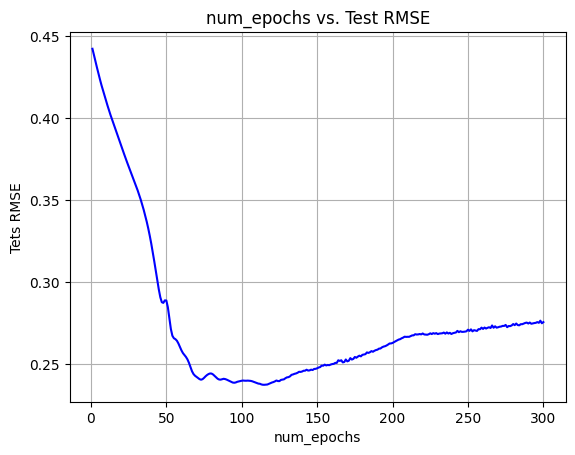

In [28]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [29]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)]

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.2371205306603663
Corresponding R^2 SCore: 0.4854757154277499
Corresponding num_epochs: 115


#### Test R^2 Score vs. num_epochs

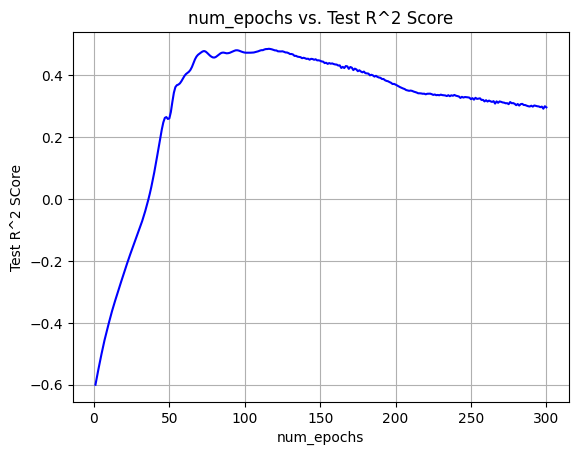

In [30]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [31]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.48631835945739543
Corresponding RMSE: 0.2371807744214886
Corresponding num_epochs: 116


#### Test Adjsuted R^2 Score (Valence) vs. num_epochs

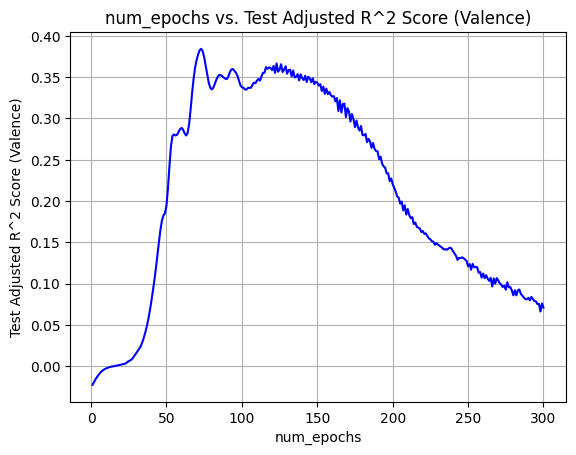

In [32]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [33]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.38441982377791284
Corresponding RMSE: 0.24022711957374765
Corresponding num_epochs: 73


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

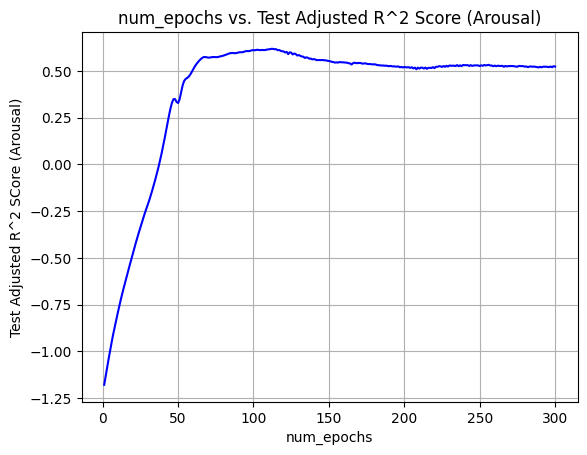

In [34]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [35]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.6177777531086619
Corresponding RMSE: 0.2377393722518685
Corresponding num_epochs: 112
